In [1]:
period=-4800
time_interval='1d'
crypto_tickers = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'XRP-USD']

%run crypto_data_loader.ipynb

yfinance version: 0.2.50
Start load crypto data with interval: 1d, from: 2011-10-11 17:00:08.299738


[*********************100%***********************]  4 of 4 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3729 entries, 2014-09-17 to 2024-12-01
Freq: D
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (BTC-USD, Adj Close)  3729 non-null   float64
 1   (ETH-USD, Adj Close)  2580 non-null   float64
 2   (SOL-USD, Adj Close)  1697 non-null   float64
 3   (XRP-USD, Adj Close)  2580 non-null   float64
 4   (BTC-USD, Close)      3729 non-null   float64
 5   (ETH-USD, Close)      2580 non-null   float64
 6   (SOL-USD, Close)      1697 non-null   float64
 7   (XRP-USD, Close)      2580 non-null   float64
 8   (BTC-USD, High)       3729 non-null   float64
 9   (ETH-USD, High)       2580 non-null   float64
 10  (SOL-USD, High)       1697 non-null   float64
 11  (XRP-USD, High)       2580 non-null   float64
 12  (BTC-USD, Low)        3729 non-null   float64
 13  (ETH-USD, Low)        2580 non-null   float64
 14  (SOL-USD, Low)        1697 non-null   float64


In [2]:
import os
import pandas as pd
import talib as ta
from talib import MA_Type
import warnings
from tqdm import tqdm
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import backtesting
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')
tqdm.pandas()

In [3]:
%run file_loader.ipynb
%run useful_functions.ipynb

In [4]:
dir = "crypto_data"
crypto_dict = {}
for name in crypto_tickers:
    f = os.path.join(dir, name+'.csv')
    if os.path.isfile(f):
        df = loading_v3(f)
        df = df.dropna()

        df = add_signal_2(df)
        df = add_pointpos_column(df, "Signal", 1e-4) # ???

        df = df.sort_values('Date').reset_index(drop=True)
        df = df.set_index('Date')

        crypto_dict[name] = df


100%|██████████| 2580/2580 [00:00<00:00, 4709.63it/s]


In [5]:
crypto_dict['BTC-USD'].describe()

,Close,High,Low,Open,Volume,chg,vol_chg,Signal,pointpos
count,3729.000000,3729.000000,3729.000000,3729.000000,3.729000e+03,3729.000000,3729.000000,3729.000000,216.000000
mean,18952.834692,19356.808803,18483.853118,18928.110771,1.818890e+10,0.210051,5.746731,0.085546,22143.669775
std,21052.380633,21487.084448,20542.869652,21017.417047,1.978368e+10,3.628450,38.785188,0.365385,21701.306001
min,178.102997,211.731003,171.509995,176.897003,5.914570e+06,-37.170000,-86.920000,0.000000,214.724906
25%,1205.010010,1222.500000,1179.689941,1201.020020,3.529690e+08,-1.250000,-15.080000,0.000000,4108.450173
50%,9303.629883,9457.417969,9141.251953,9292.841797,1.445236e+10,0.140000,-0.830000,0.000000,10666.433594
75%,30271.130859,30636.029297,29652.705078,30249.626953,2.924455e+10,1.700000,18.590000,0.000000,39591.331005
max,98997.664062,99655.500000,97232.890625,99006.742188,3.509679e+11,25.250000,543.900000,2.000000,92642.913962


In [6]:
sum([crypto_dict[key]['Signal'].value_counts() for key in crypto_dict], start=0)

Signal
0    10000
1      293
2      293
Name: count, dtype: int64

In [7]:
for df in crypto_dict.values():
    print(len(df[df.Signal != 0]))

216
137
87
146


In [8]:
plot_candlestick_with_signals(crypto_dict['BTC-USD'], start_index=3600, num_rows=100)

In [ ]:
%run backtest_strategy.ipynb

In [10]:
results = dict()

for name, df in crypto_dict.items():
    bt = Backtest(df, StopLossStrategy, cash=10000, margin=1/10, commission=0.002)
    results[name] = bt.run()

In [11]:
for name, stats in results.items():
    print("=== Stats of {} ===".format(name))
    print(stats)

=== Stats of BTC-USD ===
Start                     2014-09-17 00:00:00
End                       2024-12-01 00:00:00
Duration                   3728 days 00:00:00
Exposure Time [%]                    2.306248
Equity Final [$]                  8136.382891
Equity Peak [$]                       10000.0
Return [%]                         -18.636171
Buy & Hold Return [%]            21131.956901
Return (Ann.) [%]                   -1.998462
Volatility (Ann.) [%]                0.808181
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -18.636171
Avg. Drawdown [%]                  -18.636171
Max. Drawdown Duration     3722 days 00:00:00
Avg. Drawdown Duration     3722 days 00:00:00
# Trades                                   86
Win Rate [%]                              0.0
Best Trade [%]                      -0.199601
Worst Trade [%]                     -1.325156
Avg. Trad

In [12]:
for name, stats in results.items():
    print("=== Return of {}, {} ===".format(name, stats["Return [%]"]))


=== Return of BTC-USD, -18.63617108886704 ===
=== Return of ETH-USD, -23.790572229919533 ===
=== Return of SOL-USD, -12.603021478490955 ===
=== Return of XRP-USD, -13.437320195711472 ===


In [16]:
for name, stats in results.items():
    print("=== Win Rate of {}, {} ===".format(name, stats["Win Rate [%]"]))

=== Win Rate of BTC-USD, 0.0 ===
=== Win Rate of ETH-USD, 1.4598540145985401 ===
=== Win Rate of SOL-USD, 2.2988505747126435 ===
=== Win Rate of XRP-USD, 71.31782945736434 ===


In [13]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results.values()]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the last value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    last_value = equity.iloc[-1]
    padding = [last_value] * (max_length - len(equity))
    padded_equity = equity.tolist() + padding
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

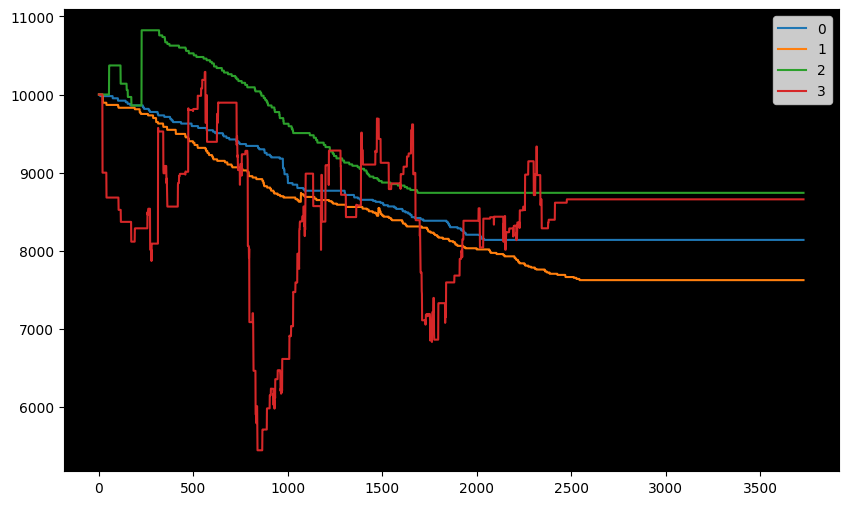

In [15]:
import matplotlib.pyplot as plt

equity_df.plot(kind='line', figsize=(10, 6), legend=True).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')